# Module and Data Importation

In [32]:
import pandas as pd
import pickle
import numpy as np
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split


## Utilities

In [33]:
import time
import matplotlib.pyplot as plt

## Modeling Tools

In [34]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from bayes_opt import BayesianOptimization

Bringing in and concatonating our absurd X

In [2]:
vectored_no_stops_mono = pickle.load(open("vectored_no_stops_mono", 'rb'))
vectored_no_stops_bi = pickle.load(open("vectored_no_stops_bi", 'rb'))
vectored_no_stops_tri = pickle.load(open("vectored_no_stops_tri", 'rb'))

In [4]:
vector_stack = [vectored_no_stops_mono, vectored_no_stops_bi, vectored_no_stops_tri]

In [5]:
X = hstack(vector_stack)

Bringing in and extracting our Y column real quick

In [6]:
test = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Sentiment-Capstone/data/food/test.csv')
train = pd.read_csv('C:/Users/Prathmun/Documents/Springboard Jupyter/Sentiment-Capstone/data/food/train.csv')
frames = [train, test]
df = pd.concat(frames)


In [7]:
y = df.Y

In [10]:
y=y.toarray()

AttributeError: 'Series' object has no attribute 'toarray'

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
print(X_train.shape)
print(y_train.shape)

(272414, 18514514)
(272414,)


### Helper Funcitons

In [13]:
def timing_buddy(model_to_fit, dictionary_string, dicto):
    funky_time_start = time.time()
    model_to_fit.fit(X_train, np.ravel(y_train))
    funky_time_stop = time.time()
    funky_train_time = funky_time_stop - funky_time_start
    dicto[dictionary_string]['training_time'] = funky_train_time
    

In [14]:
def confused_buddy(model_to_confuse, dictionary_string,dicto):
    confuse = confusion_matrix(y_test, model_to_confuse.predict(X_test))
    dicto[dictionary_string]['confuse'] = confuse

In [15]:
def recall_calculator(confuse):
    recall = 0
    tp = confuse[1][1]
    fn = confuse[1][0]
    if tp > 0 or tp ==1:
        recall = tp / (tp+fn)
    return recall

In [16]:
def precision_calculator(confuse):
    precision = 0
    tp = confuse[1][1]
    fp = confuse[0][1]
    if tp > 0 or tp ==1:
        precision = tp / (tp+fp)
    return precision

## Dummy

In [29]:
def classy_dummy(dicto, X_train, y_train, X_test, y_test):
    print('dumbo')
    dummy_clf = DummyClassifier(strategy="stratified")
    timing_buddy(dummy_clf, 'dummy', dicto)
    confused_buddy(dummy_clf, 'dummy', dicto)
    confused_buddy(dummy_clf, 'dummy', dicto)
    dicto['dummy']['ROC_AUC_Score'] = roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1])
    

In [35]:
model_set = ['dummy','SVC', 'SGDClassfier', 'BaggingClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier']
model_stats = {}
for each in model_set:
    model_stats[each] ={'confuse' : [], 'training_time' : 0, 'ROC_AUC_Score': 0, 'Hyper_Params': {}}
classy_dummy(model_stats, X_train, y_train, X_test, y_test)

dumbo


In [37]:
model_stats['dummy']

{'confuse': array([[ 2102, 12139],
        [11973, 64591]], dtype=int64),
 'training_time': 0.017003774642944336,
 'ROC_AUC_Score': 0.500910713432055,
 'Hyper_Params': {}}

## SVC

In [38]:
def SVCmodeler(dicto, X_train, y_train, X_test, y_test):
    print('Support Vector Classification')
    SupportVectorClassifier = SVC()
    timing_buddy(SupportVectorClassifier, 'SVC', dicto)
    confused_buddy(SupportVectorClassifier, 'SVC', dicto)
    dicto['SVC']['ROC_AUC_Score'] = roc_auc_score(y_test, SupportVectorClassifier.decision_function(X_test))


## Stochastic Gradiant Descent 

In [39]:
def grid_sgd_model(dicto, X_train, y_train, X_test, y_test):
    
    def SGDHyperParameterer(loss_penalty_list):
        SGD_clf = SGDClassifier(loss = loss_penalty_list[0], penalty=loss_penalty_list[1])
        SGD_clf.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, SGD_clf.predict(X_test))
        recall = recall_calculator(confuse)
        return recall
    
    
    losses= ['modified_huber', 'log']
    penalties = ['l2', 'l1', 'elasticnet']
    param_grid = {}
    count = 0
    for each_loss in losses:
        for each_penalty in penalties:
            param_grid[str(each_loss) + '-' + str(each_penalty)] = [each_loss, each_penalty]
            count+=1

    
    ###
    SGD_Hyper_param_recall_scores = {}
    for key, value in param_grid.items():
        SGD_Hyper_param_recall_scores[key] = SGDHyperParameterer(value)

    ###
    
    print('Stochastic Gradiant Descent')
    best_recall = 0
    penalty = ''
    loss = ''
    for key, value in SGD_Hyper_param_recall_scores.items():
        if value > best_recall:
            best_recall = value
            loss, penalty = key.split('-')
            
        
                                                                 
    
    ###
    SGD_clf = SGDClassifier(loss = loss, penalty= penalty)
    timing_buddy(SGD_clf, 'SGDClassfier', dicto)
    confused_buddy(SGD_clf, 'SGDClassfier', dicto)
    dicto['SGDClassfier']['ROC_AUC_Score'] = roc_auc_score(y_test, SGD_clf.decision_function(X_test))
    dicto['SGDClassfier']['Hyper_Params'] = {'Loss': loss, 'penalty':penalty}

## BaggingClassifier

In [40]:
def bayes_bagging_model(dicto, X_train, y_train, X_test, y_test):
    
    def bagginses_hyper(max_samples,max_features,n_estimators):
        Classy_Baggins_DT = BaggingClassifier(max_samples= max_samples,max_features = max_features, n_estimators=int(n_estimators))
        Classy_Baggins_DT.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, Classy_Baggins_DT.predict(X_test))
        recall = recall_calculator(confuse)
        return recall


    
    ###
    pparams ={ 'max_samples': (.1,.9),
       'max_features' : (.1,.9),
       'n_estimators': (10,500)}

    ###
    
    optimizer = BayesianOptimization(
    bagginses_hyper,
    pbounds=pparams,
    verbose=1)
    
    ######
    
    print('Bagging Classifier')
    optimizer.maximize(init_points=15, n_iter=10)
    bagginses_params= optimizer.max
    bagginses_params = bagginses_params['params']
    
    ###
    Classy_Baggins_DT = BaggingClassifier(n_estimators=int(bagginses_params['n_estimators']), 
                                          max_features=bagginses_params['max_features'],
                                          max_samples =bagginses_params['max_samples'] )
    timing_buddy(Classy_Baggins_DT, 'BaggingClassifier', dicto)
    confused_buddy(Classy_Baggins_DT, 'BaggingClassifier', dicto)
    dicto['BaggingClassifier']['ROC_AUC_Score'] = roc_auc_score(y_test, Classy_Baggins_DT.predict_proba(X_test)[:, 1])
    dicto['BaggingClassifier']['Hyper_Params'] = bagginses_params

## Random Forest Model

In [41]:
def bayes_rf_model(dicto, X_train, y_train, X_test, y_test):
    
    def bayes_RFModeler_sqrt(n_estimators, 
                             max_depth,
                             min_samples_split,
                             min_samples_leaf):
        RandoForest = RandomForestClassifier(n_estimators=int(n_estimators), max_features='sqrt', max_depth=int(max_depth),
                                             min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf))
        RandoForest.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, RandoForest.predict(X_test))
        recall = recall_calculator(confuse)
        return recall

    
    ###
    param_dicts = { 'n_estimators' : (100, 2000),
              'max_depth' : (10,60),
              'min_samples_split': (2,10),
              'min_samples_leaf' : (1,5),
              }
    ###
    
    optimizer = BayesianOptimization(
    bayes_RFModeler_sqrt,
    pbounds=param_dicts,
    verbose=1)
    
    ######
    
    print('Random Forest')
    optimizer.maximize(init_points=15, n_iter=10)
    rf_params= optimizer.max
    rf_params = rf_params['params']
    
    ###
    RandoForest = RandomForestClassifier(n_estimators=int(rf_params['n_estimators']), 
                                         max_features='sqrt',
                                         max_depth=int(rf_params['max_depth']),
                                         min_samples_split=int(rf_params['min_samples_split']),
                                         min_samples_leaf=int(rf_params['min_samples_leaf']))
    
    timing_buddy(RandoForest, 'RandomForestClassifier', dicto)
    confused_buddy(RandoForest, 'RandomForestClassifier', dicto)
    dicto['RandomForestClassifier']['ROC_AUC_Score'] = roc_auc_score(y_test, RandoForest.predict_proba(X_test)[:, 1])
    dicto['RandomForestClassifier']['Hyper_Params'] = rf_params

## AdaBooast Classifier

In [42]:
def bayes_hyper_ada_boost_model(dicto, X_train, y_train, X_test, y_test):
    
    def AdaBoost_hyper(n_estimators, learning_rate):
        adaira_the_classifier = AdaBoostClassifier(learning_rate=learning_rate,  n_estimators=int(n_estimators))
        adaira_the_classifier.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, adaira_the_classifier.predict(X_test))
        recall = recall_calculator(confuse)
        return recall

    
    ###
    ada_params = {'learning_rate' : (.1,2),
              'n_estimators':(10,500),}
    ###
    
    optimizer = BayesianOptimization(
    AdaBoost_hyper,
    pbounds=ada_params,
    verbose=1)
    
    ######
    
    print('AdaBoost')
    optimizer.maximize(init_points=15, n_iter=10)
    ada_boost_params= optimizer.max
    ada_boost_params = ada_boost_params['params']
    
    ###
    adaira_the_classifier = AdaBoostClassifier(learning_rate=ada_boost_params['learning_rate'],  n_estimators=int(ada_boost_params['n_estimators']))
    timing_buddy(adaira_the_classifier, 'AdaBoostClassifier', dicto)
    confused_buddy(adaira_the_classifier, 'AdaBoostClassifier', dicto)
    dicto['AdaBoostClassifier']['ROC_AUC_Score'] = roc_auc_score(y_test, adaira_the_classifier.predict_proba(X_test)[:, 1])
    dicto['AdaBoostClassifier']['Hyper_Params'] = ada_boost_params

## Gradiant Boosting Model

In [43]:
def bayes_hyper_grad_boosting_model(dicto, X_train, y_train, X_test, y_test):
    
    def GradBoost_hyper(n_estimators, learning_rate, max_leaf_nodes):
        grady_the_boosted = GradientBoostingClassifier(learning_rate=learning_rate,  n_estimators=int(n_estimators),
                                                      max_leaf_nodes=int(max_leaf_nodes))
        grady_the_boosted.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, grady_the_boosted.predict(X_test))
        recall = recall_calculator(confuse)
        return recall
    
    ###
    GradBoost_params = {'learning_rate' : (.1,2),
                    'n_estimators':(10,500),
                    'max_leaf_nodes':(3,50)}
    ###
    
    optimizer = BayesianOptimization(
    GradBoost_hyper,
    pbounds=GradBoost_params,
    verbose=1)
    
    ######
    
    print('Gradient Boosting')
    optimizer.maximize(init_points=15, n_iter=10)
    grad_boost_params= optimizer.max
    grad_boost_params = grad_boost_params['params']
    
    ###
    grady_the_boosted = GradientBoostingClassifier(learning_rate=grad_boost_params['learning_rate'],
                                                   n_estimators=int(grad_boost_params['n_estimators']),
                                                   max_leaf_nodes=int(grad_boost_params['max_leaf_nodes']))
    timing_buddy(grady_the_boosted, 'GradientBoostingClassifier', dicto)
    confused_buddy(grady_the_boosted, 'GradientBoostingClassifier', dicto)
    dicto['GradientBoostingClassifier']['ROC_AUC_Score'] = roc_auc_score(y_test, grady_the_boosted.predict_proba(X_test)[:, 1])
    dicto['GradientBoostingClassifier']['Hyper_Params'] = grad_boost_params
    

## HistGradientBoostingClassifier


In [44]:
def bayes_hyper_hist_grad_model(dicto, X_train, y_train, X_test, y_test):
    
    def histBoost_hyper(learning_rate, max_leaf_nodes):
        histamine_reaction = HistGradientBoostingClassifier(learning_rate=learning_rate,
                                                      max_leaf_nodes=int(max_leaf_nodes))
        histamine_reaction.fit(X_train, np.ravel(y_train))
        confuse = confusion_matrix(y_test, histamine_reaction.predict(X_test))
        recall = recall_calculator(confuse)
        return recall
    ###
    HistBoost_params = {'learning_rate' : (.1,2),
                    'max_leaf_nodes':(3,50)}
    ###
    optimizer = BayesianOptimization(
    histBoost_hyper,
    pbounds=HistBoost_params,
    verbose=1)
    
    ######
    
    print('HistGradient')
    optimizer.maximize(init_points=15, n_iter=10)
    hist_grad_params= optimizer.max
    print(hist_grad_params)
    hist_grad_params = hist_grad_params['params']
    ###
    histamine_reaction = HistGradientBoostingClassifier(learning_rate =hist_grad_params['learning_rate'],
                                                        max_leaf_nodes= int(hist_grad_params['max_leaf_nodes']))
    hist_time_start = time.time()
    histamine_reaction.fit(X_train, np.ravel(y_train))
    hist_time_stop = time.time()
    hist_train_time = hist_time_stop - hist_time_start
    ###
    dicto['HistGradientBoostingClassifier']['training_time'] = hist_train_time
    confuse = confusion_matrix(y_test, histamine_reaction.predict(X_test))
    dicto['HistGradientBoostingClassifier']['confuse'] = confuse
    dicto['HistGradientBoostingClassifier']['ROC_AUC_Score'] = roc_auc_score(y_test, histamine_reaction.predict_proba(X_test)[:, 1])    
    dicto['HistGradientBoostingClassifier']['Hyper_Params'] = hist_grad_params

## Model Evaluation

#precision = tp/(tp+fp)
maximize this for spam, don't wanna be hiding real emails

#recall= tp/(tp+fn) 
Maximize this for medical or security scenarios, don't wanna miss actual sicknesses

In [45]:
def medical_evaluator(dicto):
    bestmodel = ""
    training_time= 0
    recall = 0
    temp_recall = 0
    for key, value in dicto.items():
        
        confuse = dicto[key]['confuse']
        if type(confuse) != list:
            temp_recall = recall_calculator(confuse)

            if temp_recall > recall:

                recall = temp_recall
                bestmodel = key
                training_time = dicto[key]['training_time']
    return bestmodel, recall, training_time

In [46]:
def spam_evaluator(dicto):
    bestmodel = ""
    training_time= 0
    precision = 0
    temp_precision = 0.00000001
    for key, value in dicto.items():
        confuse = dicto[key]['confuse']
        if type(confuse) != list:
            temp_precision = precision_calculator(confuse)

            if temp_precision > precision:

                precision = temp_precision
                bestmodel = key
                training_time = dicto[key]['training_time']
    return bestmodel, precision, training_time

# Model Execution

### Aggregate Function

In [47]:
def chonky_model_aggregator(X_train, y_train, X_test, y_test):
    
    #Models to explore
    model_set = ['dummy','SVC', 'SGDClassfier', 'BaggingClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier']
    model_stats = {}
    for each in model_set:
        model_stats[each] ={'confuse' : [], 'training_time' : 0, 'ROC_AUC_Score': 0, 'Hyper_Params': {}}
    #model running
    classy_dummy(model_stats, X_train, y_train, X_test, y_test)
    SVCmodeler(model_stats, X_train, y_train, X_test, y_test)
    grid_sgd_model(model_stats, X_train, y_train, X_test, y_test)
    bayes_bagging_model(model_stats, X_train, y_train, X_test, y_test)
    
    bayes_rf_model(model_stats, X_train, y_train, X_test, y_test)
    
    bayes_hyper_ada_boost_model(model_stats, X_train, y_train, X_test, y_test)
    bayes_hyper_grad_boosting_model(model_stats, X_train, y_train, X_test, y_test)
    bayes_hyper_hist_grad_model(model_stats, X_train, y_train, X_test, y_test)


    #best_med_model, med_precision, med_time = medical_evaluator(model_stats)
    #best_spam_model, spam_recall, spam_time = spam_evaluator(model_stats)
    #print("The best medical model (Optimizing for precision) is " + best_med_model + " It's precision score was" + str(round(med_precision,3)) + " and it took " + str(round(med_time,2)) +" seconds to run.")
    #print("")
    #print("The best spam model (Optimizing for recall) is " + best_spam_model + " It's recall score was" +str(round(spam_recall, 3)) +" and it took " + str(round(spam_time, 2) +" seconds to run.")
    return model_stats



### Stats Creation

#### Wide Stats

In [ ]:
wide_data_model_stats = chonky_model_aggregator(X_train, y_train, X_test, y_test)

dumbo
Support Vector Classification


### Stats Examination

In [20]:
print(medical_evaluator(wide_data_model_stats))

('HistGradientBoostingClassifier', 0.45937850992137774, 1.0134131908416748)


In [21]:
time_dict= {}
for key, value in wide_data_model_stats.items():
    time_dict[key] = value['training_time']
    time_list = value['training_time']

time_frame = pd.Series(time_dict)
time_frame.sort_values()

dummy                               0.019005
HistGradientBoostingClassifier      1.013413
SGDClassfier                        1.589674
GradientBoostingClassifier          7.437245
AdaBoostClassifier                 54.092033
RandomForestClassifier             84.529950
BaggingClassifier                 283.049536
SVC                               425.270415
dtype: float64

In [22]:
wide_data_model_stats

{'dummy': {'confuse': array([[10938,     0],
         [ 2671,     0]], dtype=int64),
  'training_time': 0.01900458335876465,
  'ROC_AUC_Score': 0.5,
  'Hyper_Params': {}},
 'SVC': {'confuse': array([[10680,   258],
         [ 2200,   471]], dtype=int64),
  'training_time': 425.2704153060913,
  'ROC_AUC_Score': 0.7385617337816176,
  'Hyper_Params': {}},
 'SGDClassfier': {'confuse': array([[10755,   183],
         [ 2276,   395]], dtype=int64),
  'training_time': 1.5896735191345215,
  'ROC_AUC_Score': 0.7800591660603083,
  'Hyper_Params': {'Loss': 'log', 'penalty': 'l1'}},
 'BaggingClassifier': {'confuse': array([[10535,   403],
         [ 2088,   583]], dtype=int64),
  'training_time': 283.04953622817993,
  'ROC_AUC_Score': 0.7609230242216791,
  'Hyper_Params': {'max_features': 0.8118833880107019,
   'max_samples': 0.8770790457698077,
   'n_estimators': 196.67416480838722}},
 'RandomForestClassifier': {'confuse': array([[10621,   317],
         [ 2141,   530]], dtype=int64),
  'training

In [23]:
confuse_dict= {}
for key, value in wide_data_model_stats.items():
    confuse_dict[key] = value['confuse']

confuse_frame = pd.Series(confuse_dict)

precision_dict= {}
recall_dict = {}
for i in confuse_frame.index:
    precision_dict[i] = precision_calculator(confuse_frame[i])        
    recall_dict[i] = recall_calculator(confuse_frame[i])        

precision_frame = pd.Series(precision_dict)


recall_frame = pd.Series(recall_dict)

recall_frame = dict(recall_frame)

In [24]:
working_list = (recall_frame, precision_frame, time_frame)
list_of_three = pd.DataFrame(data=working_list, index=['Recall','Precision','Time_To_Train'])
list_of_three= list_of_three.transpose()
list_of_three.loc['GradientBoostingClassifier'] #recall
list_of_three.loc['SVC'] #precision
list_of_three.loc['SGDClassfier'] #time
#list_of_three.sort_values('Precision', ascending=False)
list_of_three.sort_values('Time_To_Train')



,Recall,Precision,Time_To_Train
dummy,0.000000,0.000000,0.019005
HistGradientBoostingClassifier,0.459379,0.148135,1.013413
SGDClassfier,0.147885,0.683391,1.589674
GradientBoostingClassifier,0.396855,0.405354,7.437245
AdaBoostClassifier,0.266192,0.612931,54.092033
RandomForestClassifier,0.198428,0.625738,84.529950
BaggingClassifier,0.218270,0.591278,283.049536
SVC,0.176338,0.646091,425.270415


In [25]:
best_med_model, med_recall, med_time = medical_evaluator(wide_data_model_stats)
best_spam_model, spam_precision, spam_time = spam_evaluator(wide_data_model_stats)
print("The best medical model (Optimizing for recall) is " + best_med_model + " It's recall score was" + str(round(med_recall,3)) + " and it took " + str(round(med_time,2)) +" seconds to run.")
print("")
print("The best spam model (Optimizing for precision) is " + best_spam_model +
      " It's precision score was" +str(round(spam_precision, 3)) +" and it took " + str(round(spam_time, 2) ) +" seconds to run.")

The best medical model (Optimizing for recall) is HistGradientBoostingClassifier It's recall score was0.459 and it took 1.01 seconds to run.

The best spam model (Optimizing for precision) is SGDClassfier It's precision score was0.683 and it took 1.59 seconds to run.


In [26]:
for key, value in wide_data_model_stats.items():
    if value['training_time'] !=0:
        print(key)
        print('')
        for key2, value2 in value.items():
            print(key2)
            if key2 == 'confuse':
                if type(value2) != list:
                    print('recall: ' + str(round(recall_calculator(value2),2)))
                    print('precision: ' +str(round(precision_calculator(value2),2)))
            print(value2)
            print('')
        print('')
        print('')


dummy

confuse
recall: 0
precision: 0
[[10938     0]
 [ 2671     0]]

training_time
0.01900458335876465

ROC_AUC_Score
0.5

Hyper_Params
{}



SVC

confuse
recall: 0.18
precision: 0.65
[[10680   258]
 [ 2200   471]]

training_time
425.2704153060913

ROC_AUC_Score
0.7385617337816176

Hyper_Params
{}



SGDClassfier

confuse
recall: 0.15
precision: 0.68
[[10755   183]
 [ 2276   395]]

training_time
1.5896735191345215

ROC_AUC_Score
0.7800591660603083

Hyper_Params
{'Loss': 'log', 'penalty': 'l1'}



BaggingClassifier

confuse
recall: 0.22
precision: 0.59
[[10535   403]
 [ 2088   583]]

training_time
283.04953622817993

ROC_AUC_Score
0.7609230242216791

Hyper_Params
{'max_features': 0.8118833880107019, 'max_samples': 0.8770790457698077, 'n_estimators': 196.67416480838722}



RandomForestClassifier

confuse
recall: 0.2
precision: 0.63
[[10621   317]
 [ 2141   530]]

training_time
84.52994966506958

ROC_AUC_Score
0.7749357034259812

Hyper_Params
{'max_depth': 43.64064298122785, 'min_samples

In [27]:
grad_boost_params= {'learning_rate': 1.5933283538751961, 'max_leaf_nodes': 38.81617495990627, 'n_estimators': 174.24885414610273}

In [28]:
grady_the_boosted = GradientBoostingClassifier(learning_rate=grad_boost_params['learning_rate'],
                                               n_estimators=int(grad_boost_params['n_estimators']),
                                               max_leaf_nodes=int(grad_boost_params['max_leaf_nodes']))
grady_the_boosted.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(learning_rate=1.5933283538751961, max_leaf_nodes=38,
                           n_estimators=174)

drugs_sometimes                                0.810368
age                                            0.156517
drinks_very often                              0.017674
drugs_often                                    0.006474
religion_islam but not too serious about it    0.004097
hebrew                                         0.001680
drugs_never                                    0.000561
education_graduated from college/university    0.000546
drinks_often                                   0.000234
education_graduated from masters program       0.000210
dtype: float64


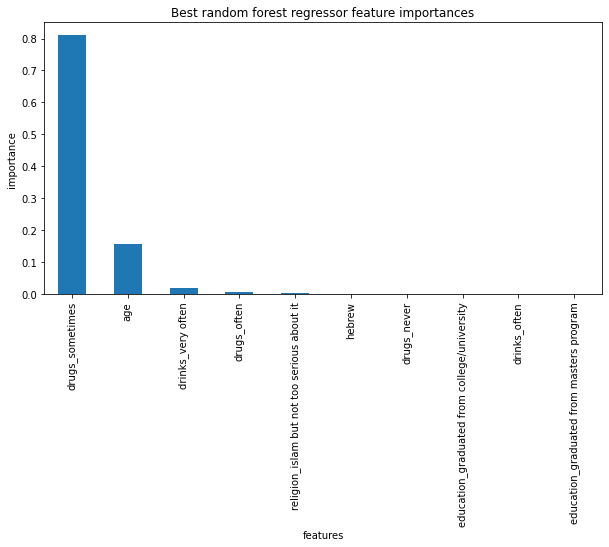

In [29]:
plt.subplots(figsize=(10, 5))
imps =grady_the_boosted.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.head(10).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');
print(rf_feat_imps.head(10))

In [30]:
rf_params = {'max_depth': 49.67439573601397, 'min_samples_leaf': 1.4729797299636367, 'min_samples_split': 3.083254181658721, 'n_estimators': 1159.2621958539908}

In [31]:
RandoForest = RandomForestClassifier(n_estimators=int(rf_params['n_estimators']), 
                                     max_features='sqrt',
                                     max_depth=int(rf_params['max_depth']),
                                     min_samples_split=int(rf_params['min_samples_split']),
                                     min_samples_leaf=int(rf_params['min_samples_leaf']))
RandoForest.fit(X_train, np.ravel(y_train))

RandomForestClassifier(max_depth=49, max_features='sqrt', min_samples_split=3,
                       n_estimators=1159)

age                                            0.067247
height                                         0.047394
drugs_sometimes                                0.041240
drugs_never                                    0.039051
multifluent_score                              0.024842
num_spoken                                     0.018552
drinks_often                                   0.017214
spanish                                        0.015430
ethnicity_multiplicity                         0.015286
white                                          0.011942
diet_anything                                  0.011719
religion_unspecified                           0.011604
education_graduated from college/university    0.011414
drugs_unspecified                              0.011324
fluency_score                                  0.010912
dtype: float64


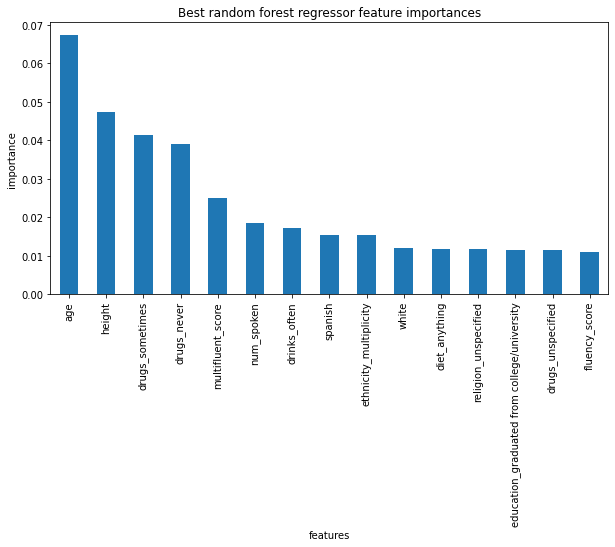

In [32]:
plt.subplots(figsize=(10, 5))
imps =RandoForest.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.head(15).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');
print(rf_feat_imps.head(15))

In [33]:
#Save this iteration.

pickle.dump( wide_data_model_stats, open( "model_stats_02122022.p", "wb" ) )

In [2]:
pickles = ['model_stats_01012022.p','model_stats_01022022.p', 'model_stats_01032022.p', 'model_stats_01222022.p', "model_stats_01242022.p", "model_stats_01252022.p", "model_stats_01262022.p", "model_stats_02122022.p"]
unpickles = []
for each in pickles:
    file = open(each, 'rb')
    unpickles.append(pickle.load(file))
    file.close()


In [9]:
for each in unpickles:
    best_spam_model, spam_precision, spam_time = spam_evaluator(each)
    print(best_spam_model, round(spam_precision,2), round(spam_time,2))

SVC 0.65 404.59
SVC 0.65 433.94
SVC 0.65 416.3
SVC 0.65 403.76
SVC 0.65 391.98
SVC 0.65 382.59
SVC 0.65 417.13
SGDClassfier 0.68 1.59


In [30]:
for each in unpickles:
    best_med_model, med_recall, med_time = medical_evaluator(each)
    print(best_med_model, round(med_recall,2), round(med_time,2))

GradientBoostingClassifier 0.43 21.42
GradientBoostingClassifier 0.64 97.03
GradientBoostingClassifier 0.41 3.42
HistGradientBoostingClassifier 0.51 1.34
HistGradientBoostingClassifier 0.5 0.61
GradientBoostingClassifier 0.43 76.2
HistGradientBoostingClassifier 0.59 0.65
HistGradientBoostingClassifier 0.46 1.01


In [34]:
    best_med_model, med_recall, med_time = medical_evaluator(unpickles[1])
    print(best_med_model, round(med_recall,2), round(med_time,2))

GradientBoostingClassifier 0.64 97.03


In [40]:
print(recall_calculator(model_stats['dummy']['confuse']))
print(' ')
print(model_stats['dummy'])

0.18757019842755523
 
{'confuse': array([[8821, 2117],
       [2170,  501]], dtype=int64), 'training_time': 0.01799464225769043, 'ROC_AUC_Score': 0.49406716964800546, 'Hyper_Params': {}}


In [48]:
print('% increase in accuracy from stratified dummy classifier')
print(((.64 -.19) / 0.19)*100)


% increase in accuracy from stratified dummy classifier
236.84210526315786


In [52]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, np.ravel(y_train))
predictions = dummy_clf.predict(X_test)

In [60]:
type(predictions)
dummy_predictions = pd.Series(predictions)

In [64]:
def yesnos(yesno):
    if yesno == 'no':
        return 0
    else:
        return 1
dummy_1_and_0s = dummy_predictions.apply(yesnos)

In [69]:
grad_boost_params = unpickles[1]['GradientBoostingClassifier']['Hyper_Params']

In [72]:
grady_the_boosted = GradientBoostingClassifier(learning_rate=grad_boost_params['learning_rate'],
                                                   n_estimators=int(grad_boost_params['n_estimators']),
                                                   max_leaf_nodes=int(grad_boost_params['max_leaf_nodes']))
grady_the_boosted.fit(X_train, np.ravel(y_train))
gdb_predicts = grady_the_boosted.predict(X_test)


array(['no', 'no', 'no', ..., 'yes', 'yes', 'yes'], dtype=object)

In [75]:
gdb_predicts = pd.Series(gdb_predicts)
gdb_1_and_0s = gdb_predicts.apply(yesnos)

In [80]:
t_test_block = y_test
t_test_block['dummy_predicts'] = dummy_1_and_0s
t_test_block['gdb_predicts'] = gdb_1_and_0s
t_test_block['smokes']= t_test_block['smokes'].apply(yesnos)

In [85]:
t_test_block

,smokes,dummy_predicts,gdb_predicts
0,1,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
13604,0,0,0
13605,1,0,0
13606,0,0,1
13607,1,0,1


In [93]:
def correcter(predict):
    print(type(predict))
#     if t_test_block['smokes'] == predict:
#         return 1
#     else:
#         return 0

In [98]:
t_test_block['dummy_score'] = np.where(t_test_block['smokes'] == t_test_block['dummy_predicts'], 1,0)

In [105]:
t_test_block

,smokes,dummy_predicts,gdb_predicts,dummy_score,gdb_score
0,1,0,0,0,0
1,0,0,0,1,1
2,0,0,0,1,1
3,0,0,0,1,1
4,0,0,0,1,1
...,...,...,...,...,...
13604,0,0,0,1,1
13605,1,0,0,0,0
13606,0,0,1,1,0
13607,1,0,1,0,1


In [100]:
t_test_block['gdb_score'] = np.where(t_test_block['smokes'] == t_test_block['gdb_predicts'], 1,0)

In [103]:
from scipy.stats import ttest_ind

In [104]:
ttest_ind(t_test_block['dummy_score'],t_test_block['gdb_score'])

Ttest_indResult(statistic=7.619843367171574, pvalue=2.622375421065683e-14)